  0.016759 seconds (37.76 k allocations: 14.188 MiB, 63.73% gc time)


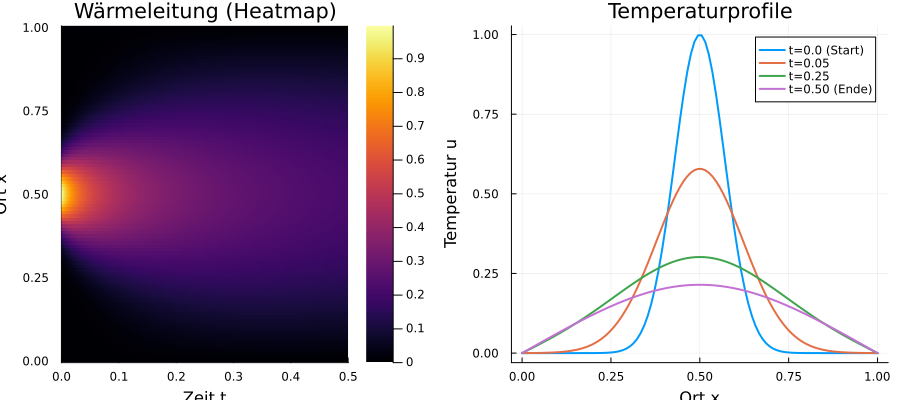

In [7]:
using SparseArrays
using LinearAlgebra
using Plots

"""
Löst die 1D-Wärmeleitungsgleichung (Diffusionsgleichung) mit Crank-Nicolson.
Gibt x-Koordinaten, t-Koordinaten und die Lösungsmatrix U zurück.
"""
function crank_nicolson_vis(L=1.0, T=0.2, N=100, M=1000, alpha=0.1)
    # Gitter Parameter
    dx = L / (N - 1)
    dt = T / M
    x = range(0, L, length=N)
    t_range = range(0, T, length=M+1)

    # Courant-Zahl
    r = (alpha * dt) / (2 * dx^2)
    
    # Anfangsbedingung: Ein "Hut" in der Mitte
    u = exp.(-100 .* (x .- 0.5).^2)
    
    # Randbedingungen (Dirichlet = 0)
    u[1] = 0.0
    u[end] = 0.0

    # Speicher für die gesamte Zeitentwicklung
    U_history = zeros(N, M+1)
    U_history[:, 1] = u

    # Matrizen erstellen (nur für innere Punkte)
    n_inner = N - 2
    
    # Matrix A (Linke Seite, implizit)
    main_diag_A = (1 + 2 * r) * ones(n_inner)
    off_diag_A  = -r * ones(n_inner - 1)
    
    A = spdiagm(
        -1 => off_diag_A, 
         0 => main_diag_A, 
         1 => off_diag_A
    )

    # Matrix B (Rechte Seite, explizit)
    main_diag_B = (1 - 2 * r) * ones(n_inner)
    off_diag_B  = r * ones(n_inner - 1)

    B = spdiagm(
        -1 => off_diag_B, 
         0 => main_diag_B, 
         1 => off_diag_B
    )

    # Pre-Faktorisierung der Matrix A (LU-Zerlegung)
    A_fact = factorize(A)

    # Zeitschleife
    u_inner = u[2:end-1]

    @time begin
    for n in 1:M
        # Rechte Seite berechnen
        rhs = B * u_inner
        
        # Lösen: A * u_new = rhs
        u_inner = A_fact \ rhs
        
        # Ergebnis speichern
        U_history[1, n+1] = 0.0
        U_history[2:end-1, n+1] = u_inner
        U_history[end, n+1] = 0.0
    end
    end
    return x, t_range, U_history
end

# --- Berechnung & Plotting ---

# Simulation starten
x, t, U = crank_nicolson_vis(1.0, 0.5, 100, 2000, 0.1)

# Plot 1: Heatmap
p1 = heatmap(
    t, x, U, 
    xlabel="Zeit t", ylabel="Ort x", 
    title="Wärmeleitung (Heatmap)",
    color=:inferno
)

# Plot 2: Profile zu verschiedenen Zeitpunkten
p2 = plot(
    x, U[:, 1], label="t=0.0 (Start)", lw=2, 
    xlabel="Ort x", ylabel="Temperatur u", 
    title="Temperaturprofile"
)
plot!(p2, x, U[:, 200], label="t=0.05", lw=2)
plot!(p2, x, U[:, 1000], label="t=0.25", lw=2)
plot!(p2, x, U[:, end], label="t=0.50 (Ende)", lw=2)

plot(p1, p2, layout=(1, 2), size=(900, 400))